In [1]:
import seaborn as sns
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import matplotlib
from sklearn.metrics import confusion_matrix
import math
import xgboost as xgb
from scipy.stats import skew
from scipy import stats
import statsmodels
from sklearn.metrics import accuracy_score

import sklearn
import plotly.offline as py
import plotly.graph_objs as go
import plotly.tools as tls

import warnings
warnings.filterwarnings('ignore')

from sklearn.ensemble import (RandomForestClassifier, AdaBoostClassifier, 
                              GradientBoostingClassifier, ExtraTreesClassifier)
from sklearn.svm import SVC
from sklearn.model_selection import KFold

%matplotlib inline

In [2]:
train = pd.read_csv("../datasets/train.csv")
test = pd.read_csv("../datasets/test.csv")

# full_data = [train, test]

In [3]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [5]:
train = train.set_index("PassengerId")
train['train'] = 1
test = test.set_index("PassengerId")
test['train'] = 0

data = train.append(test, ignore_index=True)

In [6]:
data['Survived'].unique()

array([ 0.,  1., nan])

In [7]:
data.columns

Index(['Age', 'Cabin', 'Embarked', 'Fare', 'Name', 'Parch', 'Pclass', 'Sex',
       'SibSp', 'Survived', 'Ticket', 'train'],
      dtype='object')

In [8]:
data.describe()

,Age,Fare,Parch,Pclass,SibSp,Survived,train
count,1046.000000,1308.000000,1309.000000,1309.000000,1309.000000,891.000000,1309.000000
mean,29.881138,33.295479,0.385027,2.294882,0.498854,0.383838,0.680672
std,14.413493,51.758668,0.865560,0.837836,1.041658,0.486592,0.466394
min,0.170000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
25%,21.000000,7.895800,0.000000,2.000000,0.000000,0.000000,0.000000
50%,28.000000,14.454200,0.000000,3.000000,0.000000,0.000000,1.000000
75%,39.000000,31.275000,0.000000,3.000000,1.000000,1.000000,1.000000
max,80.000000,512.329200,9.000000,3.000000,8.000000,1.000000,1.000000


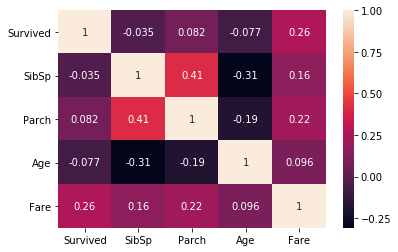

In [9]:
 g = sns.heatmap(train[["Survived","SibSp","Parch","Age","Fare"]].corr(),annot=True)

In [10]:
def compare_dist(data, var1, var2):
    print(data[[var1, var2]][data[var2].isnull()==False].groupby([var1],
    as_index=False).mean().sort_values(by=var2, ascending=False))
    g = sns.FacetGrid(data, col=var2).map(plt.hist, var1)
    
def compare_mean(data, var1, var2):
    return data[[var1, var2]][data[var2].isnull()==False].groupby([var1],
        as_index=False).mean().sort_values(by=var2, ascending=False)


def compare_hist(data, var):
    max_range = data[var].max() * 1.2
    bins = np.linspace(0, max_range)
    plt.hist(data[data['Survived']==0][var], bins,
            alpha=0.5, normed=True, label='Did Not Survive')
    plt.hist(data[data['Survived']==1][var], bins,
            alpha=0.5, normed=True, label='Survived')
    plt.legend(loc='upper right')
    plt.show()
    
def categorical_survival_rate(data, var):
    all_counts = dict(data[var].value_counts())
    survived_counts = dict(data[var][data['Survived']==1].value_counts())
    died_counts = dict(data[var][data['Survived']==0].value_counts())
    
    categories = list(data[var].unique())
    categories = [category for category in categories if str(category) != 'nan']
    try:
        categories.sort()
    except TypeError:
        print("TypeError")
    survived_rate=[]
    died_rate=[]
    
    for category in categories:
        survived_rate.append(survived_counts[category] / all_counts[category])
        died_rate.append(died_counts[category] / all_counts[category])
        
    for i, category in enumerate(categories):
        categories[i] = str(category)
        
    plt.bar(categories, survived_rate, align='center', alpha=0.5, color = 'r')
    plt.ylabel('Survival Rate')
    plt.title(f'Survival Rate by {var}')
    plt.show()

    plt.bar(categories, died_rate, align='center', alpha=0.5, color = 'b')
    plt.ylabel('Death Rate')
    plt.title(f'Death Rate by {var}')
    plt.show()

### Parch vs Survivied

   Parch  Survived
3      3  0.600000
1      1  0.550847
2      2  0.500000
0      0  0.343658
5      5  0.200000
4      4  0.000000
6      6  0.000000


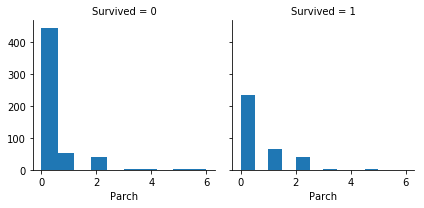

In [11]:
compare_dist(train, 'Parch', 'Survived')

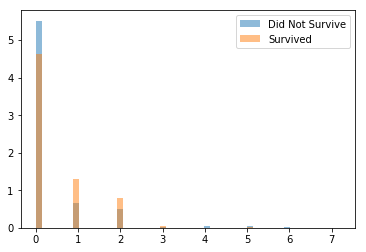

In [12]:
compare_hist(train, 'Parch')

### SibSp vs Survived

   SibSp  Survived
1      1  0.535885
2      2  0.464286
0      0  0.345395
3      3  0.250000
4      4  0.166667
5      5  0.000000
6      8  0.000000


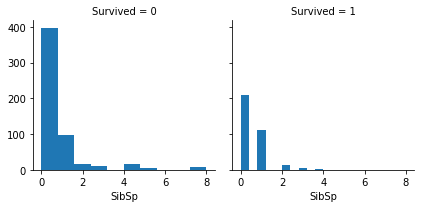

In [13]:
compare_dist(train, 'SibSp', 'Survived')

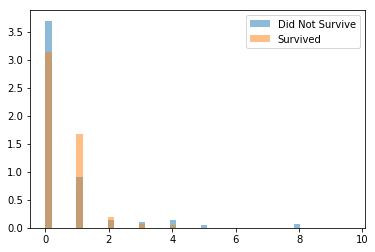

In [14]:
compare_hist(train, 'SibSp')

### Fare vs Survived

         Fare  Survived
247  512.3292       1.0
196   57.9792       1.0
89    13.8583       1.0
88    13.7917       1.0
86    13.4167       1.0
83    12.6500       1.0
81    12.4750       1.0
79    12.2875       1.0
194   56.9292       1.0
77    12.0000       1.0
195   57.0000       1.0
74    11.1333       1.0
197   59.4000       1.0
52     8.5167       1.0
201   63.3583       1.0
202   65.0000       1.0
68     9.8417       1.0
204   69.3000       1.0
207   71.2833       1.0
209   75.2500       1.0
210   76.2917       1.0
211   76.7292       1.0
213   77.9583       1.0
214   78.2667       1.0
90    13.8625       1.0
191   55.4417       1.0
190   55.0000       1.0
188   52.5542       1.0
142   26.3875       1.0
141   26.2875       1.0
..        ...       ...
158   31.2750       0.0
136   25.9250       0.0
156   30.6958       0.0
147   27.9000       0.0
148   28.5000       0.0
113   18.0000       0.0
176   40.1250       0.0
198   61.1750       0.0
95    14.4583       0.0
71    10.4625   

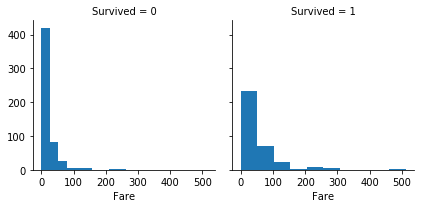

In [15]:
compare_dist(train, 'Fare', 'Survived')

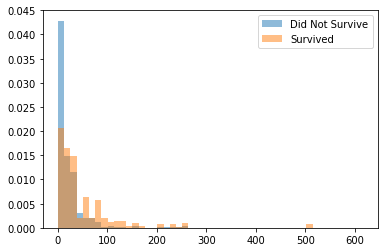

In [16]:
compare_hist(train, 'Fare')

### Age vs Survived

      Age  Survived
0    0.42  1.000000
9    5.00  1.000000
79  63.00  1.000000
68  53.00  1.000000
1    0.67  1.000000
17  13.00  1.000000
16  12.00  1.000000
87  80.00  1.000000
2    0.75  1.000000
4    0.92  1.000000
3    0.83  1.000000
7    3.00  0.833333
20  15.00  0.800000
5    1.00  0.714286
8    4.00  0.700000
10   6.00  0.666667
63  48.00  0.666667
64  49.00  0.666667
47  35.00  0.611111
35  27.00  0.611111
74  58.00  0.600000
31  24.00  0.500000
65  50.00  0.500000
70  55.00  0.500000
72  56.00  0.500000
76  60.00  0.500000
78  62.00  0.500000
43  32.50  0.500000
42  32.00  0.500000
67  52.00  0.500000
..    ...       ...
13   9.00  0.250000
15  11.00  0.250000
27  21.00  0.208333
25  20.00  0.200000
57  43.00  0.200000
50  37.00  0.166667
62  47.00  0.111111
84  70.50  0.000000
83  70.00  0.000000
80  64.00  0.000000
81  65.00  0.000000
85  71.00  0.000000
86  74.00  0.000000
75  59.00  0.000000
77  61.00  0.000000
82  66.00  0.000000
40  30.50  0.000000
14  10.00  0.000000


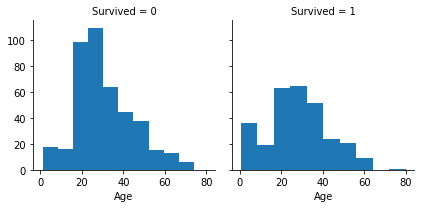

In [17]:
compare_dist(train, 'Age', 'Survived')

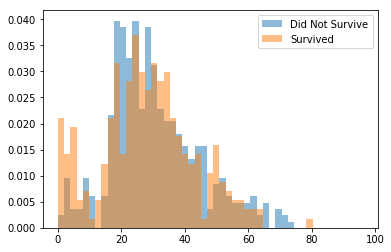

In [18]:
compare_hist(train, 'Age')

### Sex vs Survived

In [19]:
compare_mean(train, 'Sex', 'Survived')

,Sex,Survived
0,female,0.742038
1,male,0.188908


In [20]:
# all_counts = dict(data['Sex'].value_counts())
# survived_counts = dict(data['Sex'][data['Survived']==1].value_counts())
# died_counts = dict(data['Sex'][data['Survived']==0].value_counts())


# genders = ['male', 'female']
# survived_rate = [survived_counts['male'] / all_counts['male'],
#                  survived_counts['female'] / all_counts['female']]
# died_list = [died_counts['male'] / all_counts['male'],
#              died_counts['female'] / all_counts['female']]

In [21]:
# plt.bar(genders, survived_rate, align='center', alpha=0.5, color = 'r')
# plt.ylabel('Survival Rate')
# plt.title('Survival Rate by Gender')
# plt.show()

# plt.bar(genders, died_list, align='center', alpha=0.5, color = 'b')
# plt.ylabel('Death Rate')
# plt.title('Death Rate by Gender')
# plt.show()

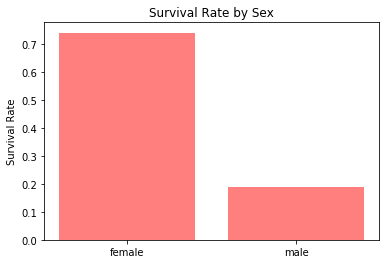

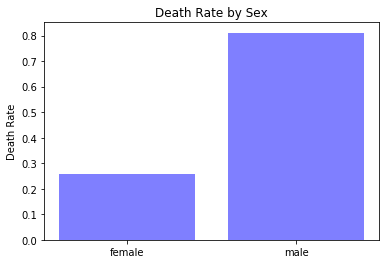

In [22]:
categorical_survival_rate(train, 'Sex')

### Pclass vs Survived


   Pclass  Survived
0       1  0.629630
1       2  0.472826
2       3  0.242363


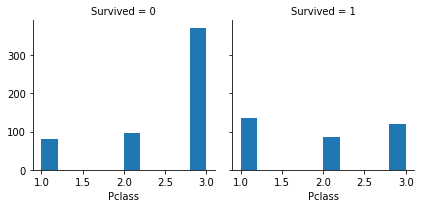

In [23]:
compare_dist(train, 'Pclass', 'Survived')

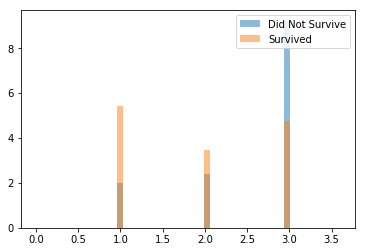

In [24]:
compare_hist(train, 'Pclass')

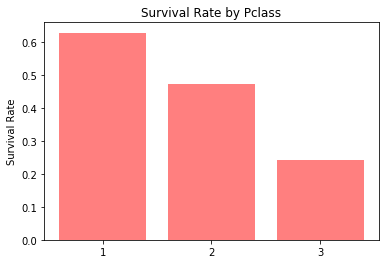

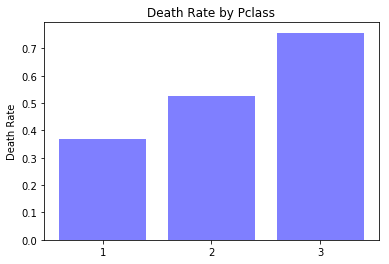

In [25]:
categorical_survival_rate(train, 'Pclass')

In [26]:
# all_counts = dict(data['Pclass'].value_counts())
# survived_counts = dict(data['Pclass'][data['Survived']==1].value_counts())
# died_counts = dict(data['Pclass'][data['Survived']==0].value_counts())


# p_class = ['1', '2', '3']
# survived_rate = [survived_counts[1] / all_counts[1],
#                  survived_counts[2] / all_counts[2],
#                 survived_counts[3] / all_counts[3]]
# died_list = [died_counts[1] / all_counts[1],
#              died_counts[2] / all_counts[2],
#             died_counts[3] / all_counts[3]]

In [27]:
# plt.bar(p_class, survived_rate, align='center', alpha=0.5, color = 'r')
# plt.ylabel('Survival Rate')
# plt.title('Survival Rate by Class')
# plt.show()

# plt.bar(p_class, died_list, align='center', alpha=0.5, color = 'b')
# plt.ylabel('Death Rate')
# plt.title('Death Rate by Class')
# plt.show()

### Embarked vs Survived

In [28]:
data['Embarked'].value_counts()

S    914
C    270
Q    123
Name: Embarked, dtype: int64

In [29]:
compare_mean(train, 'Embarked', 'Survived')

,Embarked,Survived
0,C,0.553571
1,Q,0.389610
2,S,0.336957


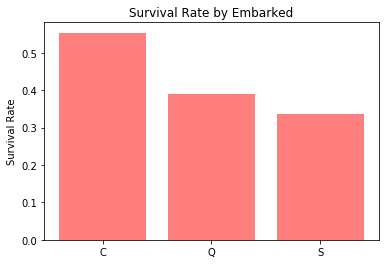

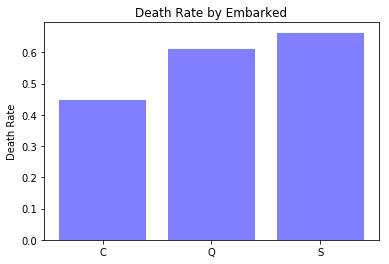

In [30]:
categorical_survival_rate(train, 'Embarked')

## Feature Engineering/ Data Cleaning

In [31]:
data.isnull().sum()

Age          263
Cabin       1014
Embarked       2
Fare           1
Name           0
Parch          0
Pclass         0
Sex            0
SibSp          0
Survived     418
Ticket         0
train          0
dtype: int64

In [32]:
data['Name_length'] = data['Name'].apply(len)

In [33]:
data['FamilySize'] = data['SibSp'] + data['Parch'] + 1

In [34]:
data['FamilySize'].describe()

count    1309.000000
mean        1.883881
std         1.583639
min         1.000000
25%         1.000000
50%         1.000000
75%         2.000000
max        11.000000
Name: FamilySize, dtype: float64

In [35]:
data['IsAlone'] = np.where(data["FamilySize"]==1, 1, 0)

In [36]:
data['Embarked'] = data['Embarked'].fillna('S')

In [37]:
train = data[data['train']==1]
test = data[data['train']==0]

In [38]:
train['Fare'] = train['Fare'].fillna(train['Fare'].median())
test['Fare'] = test['Fare'].fillna(test['Fare'].median())

In [39]:
data = train.append(test, ignore_index=True)

In [40]:
len(data)

1309

In [41]:
data['Fare'].describe()

count    1309.000000
mean       33.281086
std        51.741500
min         0.000000
25%         7.895800
50%        14.454200
75%        31.275000
max       512.329200
Name: Fare, dtype: float64

In [42]:
pd.qcut(data['Fare'], 10)

0         (-0.001, 7.57]
1        (41.579, 78.02]
2          (7.854, 8.05]
3        (41.579, 78.02]
4          (7.854, 8.05]
5           (8.05, 10.5]
6        (41.579, 78.02]
7       (14.454, 21.558]
8         (10.5, 14.454]
9        (26.82, 41.579]
10      (14.454, 21.558]
11       (21.558, 26.82]
12         (7.854, 8.05]
13       (26.82, 41.579]
14         (7.57, 7.854]
15      (14.454, 21.558]
16       (26.82, 41.579]
17        (10.5, 14.454]
18      (14.454, 21.558]
19        (-0.001, 7.57]
20       (21.558, 26.82]
21        (10.5, 14.454]
22         (7.854, 8.05]
23       (26.82, 41.579]
24      (14.454, 21.558]
25       (26.82, 41.579]
26        (-0.001, 7.57]
27      (78.02, 512.329]
28         (7.854, 8.05]
29         (7.854, 8.05]
              ...       
1279       (7.57, 7.854]
1280    (14.454, 21.558]
1281    (78.02, 512.329]
1282     (26.82, 41.579]
1283    (14.454, 21.558]
1284        (8.05, 10.5]
1285     (21.558, 26.82]
1286     (41.579, 78.02]
1287      (-0.001, 7.57]


In [43]:
fare_labels = ['fare_0','fare_1', 'fare_2', 'fare_3', 'fare_4',
              'fare_5', 'fare_6', 'fare_7', 'fare_8',
              'fare_9']

data['Fare_C'] = pd.qcut(data['Fare'], 10, labels = fare_labels)

In [44]:
data.head()

,Age,Cabin,Embarked,Fare,Name,Parch,Pclass,Sex,SibSp,Survived,Ticket,train,Name_length,FamilySize,IsAlone,Fare_C
0,22.0,NaN,S,7.2500,"Braund, Mr. Owen Harris",0,3,male,1,0.0,A/5 21171,1,23,2,0,fare_0
1,38.0,C85,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,1,female,1,1.0,PC 17599,1,51,2,0,fare_8
2,26.0,NaN,S,7.9250,"Heikkinen, Miss. Laina",0,3,female,0,1.0,STON/O2. 3101282,1,22,1,1,fare_2
3,35.0,C123,S,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,1,female,1,1.0,113803,1,44,2,0,fare_8
4,35.0,NaN,S,8.0500,"Allen, Mr. William Henry",0,3,male,0,0.0,373450,1,24,1,1,fare_2


In [45]:
compare_mean(data, 'Fare_C', 'Survived')

,Fare_C,Survived
9,fare_9,0.758621
8,fare_8,0.529412
6,fare_6,0.511364
4,fare_4,0.428571
5,fare_5,0.425287
7,fare_7,0.381443
1,fare_1,0.298851
3,fare_3,0.230769
2,fare_2,0.179245
0,fare_0,0.141304


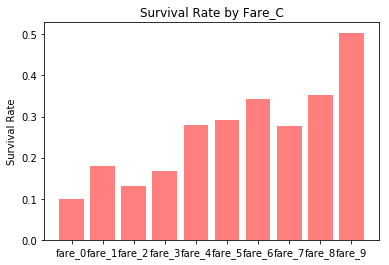

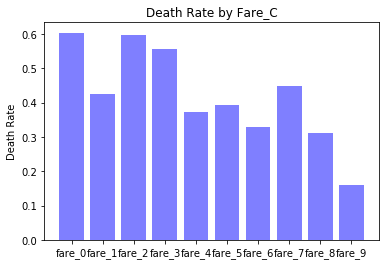

In [46]:
categorical_survival_rate(data, 'Fare_C')

In [47]:
data.drop(['Cabin'], axis=1, inplace=True)

In [48]:
data['Title'] = data.Name.str.extract(' ([A-Za-z]+)\.', expand=False)

In [49]:
data.head()

,Age,Embarked,Fare,Name,Parch,Pclass,Sex,SibSp,Survived,Ticket,train,Name_length,FamilySize,IsAlone,Fare_C,Title
0,22.0,S,7.2500,"Braund, Mr. Owen Harris",0,3,male,1,0.0,A/5 21171,1,23,2,0,fare_0,Mr
1,38.0,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,1,female,1,1.0,PC 17599,1,51,2,0,fare_8,Mrs
2,26.0,S,7.9250,"Heikkinen, Miss. Laina",0,3,female,0,1.0,STON/O2. 3101282,1,22,1,1,fare_2,Miss
3,35.0,S,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,1,female,1,1.0,113803,1,44,2,0,fare_8,Mrs
4,35.0,S,8.0500,"Allen, Mr. William Henry",0,3,male,0,0.0,373450,1,24,1,1,fare_2,Mr


In [50]:
print(data['Title'].value_counts())
print(f'Null Values: {data["Title"].isnull().sum()}')

Mr          757
Miss        260
Mrs         197
Master       61
Dr            8
Rev           8
Col           4
Ms            2
Major         2
Mlle          2
Lady          1
Dona          1
Countess      1
Jonkheer      1
Capt          1
Mme           1
Sir           1
Don           1
Name: Title, dtype: int64
Null Values: 0


In [51]:
data['Title'] = data['Title'].replace('Mlle', 'Miss')
data['Title'] = data['Title'].replace('Ms', 'Miss')
data['Title'] = data['Title'].replace('Mme', 'Mrs')

In [52]:
print(data['Title'].value_counts())
print(f'Null Values: {data["Title"].isnull().sum()}')

Mr          757
Miss        264
Mrs         198
Master       61
Dr            8
Rev           8
Col           4
Major         2
Don           1
Sir           1
Countess      1
Lady          1
Dona          1
Jonkheer      1
Capt          1
Name: Title, dtype: int64
Null Values: 0


### Exploring conditional distribution, Age | Title

In [53]:
rare_titles = ['Dr', 'Rev', 'Col', 'Major', 'Jonkheer', 'Don',
              'Capt', 'Dona', 'Lady', 'Sir', 'Countess']
common_titles = ['Mr', 'Miss', 'Mrs', 'Master']
filtered_data = data.loc[data['Title'].isin(common_titles), :]

In [54]:
filtered_data.head()

,Age,Embarked,Fare,Name,Parch,Pclass,Sex,SibSp,Survived,Ticket,train,Name_length,FamilySize,IsAlone,Fare_C,Title
0,22.0,S,7.2500,"Braund, Mr. Owen Harris",0,3,male,1,0.0,A/5 21171,1,23,2,0,fare_0,Mr
1,38.0,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,1,female,1,1.0,PC 17599,1,51,2,0,fare_8,Mrs
2,26.0,S,7.9250,"Heikkinen, Miss. Laina",0,3,female,0,1.0,STON/O2. 3101282,1,22,1,1,fare_2,Miss
3,35.0,S,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,1,female,1,1.0,113803,1,44,2,0,fare_8,Mrs
4,35.0,S,8.0500,"Allen, Mr. William Henry",0,3,male,0,0.0,373450,1,24,1,1,fare_2,Mr


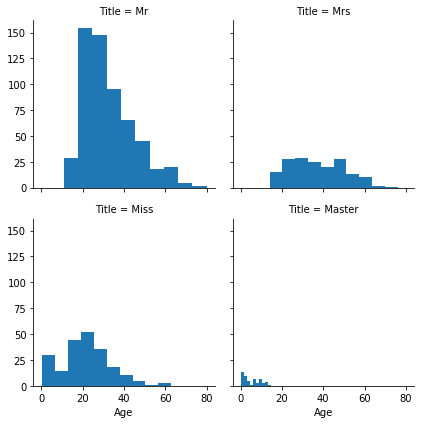

In [55]:
g = sns.FacetGrid(filtered_data, col="Title", col_wrap = 2).map(plt.hist, 'Age')

In [56]:
data['Age'][data["Title"]=="Mr"].describe()

count    581.000000
mean      32.252151
std       12.422089
min       11.000000
25%       23.000000
50%       29.000000
75%       39.000000
max       80.000000
Name: Age, dtype: float64

In [57]:
data['Age'][data["Title"]=="Mrs"].describe()

count    171.000000
mean      36.918129
std       12.902087
min       14.000000
25%       26.500000
50%       35.000000
75%       46.000000
max       76.000000
Name: Age, dtype: float64

In [58]:
data['Age'][data["Title"]=="Miss"].describe()

count    213.000000
mean      21.824366
std       12.171431
min        0.170000
25%       15.000000
50%       22.000000
75%       30.000000
max       63.000000
Name: Age, dtype: float64

In [59]:
data['Age'][data["Title"]=="Master"].describe()

count    53.000000
mean      5.482642
std       4.161554
min       0.330000
25%       2.000000
50%       4.000000
75%       9.000000
max      14.500000
Name: Age, dtype: float64

In [60]:
# Find number of missing ages for each title

for title in data["Title"].unique():
    sum_nan = data["Age"][data["Title"]==title].isnull().sum()
    print(f'Number of Age Nan for {title}: {sum_nan}')

Number of Age Nan for Mr: 176
Number of Age Nan for Mrs: 27
Number of Age Nan for Miss: 51
Number of Age Nan for Master: 8
Number of Age Nan for Don: 0
Number of Age Nan for Rev: 0
Number of Age Nan for Dr: 1
Number of Age Nan for Major: 0
Number of Age Nan for Lady: 0
Number of Age Nan for Sir: 0
Number of Age Nan for Col: 0
Number of Age Nan for Capt: 0
Number of Age Nan for Countess: 0
Number of Age Nan for Jonkheer: 0
Number of Age Nan for Dona: 0


In [61]:
mr_median = data['Age'][data["Title"]=="Mr"].median()
mr_q1 = float(data['Age'][data["Title"]=="Mr"].quantile([0.25]))
mr_q3 = float(data['Age'][data["Title"]=="Mr"].quantile([0.75]))
mr_null_count = data['Age'][data['Title']=='Mr'].isnull().sum()
mr_rand_list = np.random.randint(mr_q1, mr_q3, size=mr_null_count)

mrs_median = data['Age'][data["Title"]=="Mrs"].median()
mrs_q1 = float(data['Age'][data["Title"]=="Mrs"].quantile([0.25]))
mrs_q3 = float(data['Age'][data["Title"]=="Mrs"].quantile([0.75]))
mrs_null_count = data['Age'][data['Title']=='Mrs'].isnull().sum()
mrs_rand_list = np.random.randint(mrs_q1, mrs_q3, size=mrs_null_count)

miss_median = data['Age'][data["Title"]=="Miss"].median()
miss_q1 = float(data['Age'][data["Title"]=="Miss"].quantile([0.25]))
miss_q3 = float(data['Age'][data["Title"]=="Miss"].quantile([0.75]))
miss_null_count = data['Age'][data['Title']=='Miss'].isnull().sum()
miss_rand_list = np.random.randint(miss_q1, miss_q3, size=miss_null_count)

master_median = data['Age'][data["Title"]=="Master"].median()
master_q1 = float(data['Age'][data["Title"]=="Master"].quantile([0.25]))
master_q3 = float(data['Age'][data["Title"]=="Master"].quantile([0.75]))
master_null_count = data['Age'][data['Title']=='Master'].isnull().sum()
master_rand_list = np.random.randint(master_q1, master_q3,
                                     size=master_null_count)

doctor_median = mr_median + 15
doctor_q1 = mr_q1 + 15
doctor_q3 = mr_q3 + 15
doctor_null_count = 1
doctor_rand_list = np.random.randint(doctor_q1, doctor_q3,
                                     size=doctor_null_count)

In [62]:
mr_null_index = list(data['Age'][data['Title']=='Mr'][data['Age'].isnull()].index)
mrs_null_index = list(data['Age'][data['Title']=='Mrs'][data['Age'].isnull()].index)
miss_null_index = list(data['Age'][data['Title']=='Miss'][data['Age'].isnull()].index)
master_null_index = list(data['Age'][data['Title']=='Master'][data['Age'].isnull()].index)

In [63]:
print(len(mr_null_index))
print(len(mrs_null_index))
print(len(miss_null_index))
print(len(master_null_index))

176
27
51
8


In [64]:
mr_rand_series = pd.Series(mr_rand_list, index = mr_null_index)
mrs_rand_series = pd.Series(mrs_rand_list, index = mrs_null_index)
miss_rand_series = pd.Series(miss_rand_list, index = miss_null_index)
master_rand_series = pd.Series(master_rand_list, index = master_null_index)

In [65]:
print(len(mr_rand_series))
print(len(mrs_rand_series))
print(len(miss_rand_series))
print(len(master_rand_series))

176
27
51
8


In [66]:
dr_rand = int(doctor_rand_list)

In [67]:
data['Age'][data['Title']=='Mr'] = data['Age'][data['Title']=='Mr'].fillna(mr_rand_series)
data['Age'][data['Title']=='Mrs'] = data['Age'][data['Title']=='Mrs'].fillna(mrs_rand_series)
data['Age'][data['Title']=='Miss'] = data['Age'][data['Title']=='Miss'].fillna(miss_rand_series)
data['Age'][data['Title']=='Master'] = data['Age'][data['Title']=='Master'].fillna(master_rand_series)

data['Age'][data['Title']=='Dr'] = data['Age'][data['Title']=='Dr'].fillna(dr_rand)

In [68]:
# Find number of missing ages for each title

for title in data["Title"].unique():
    sum_nan = data["Age"][data["Title"]==title].isnull().sum()
    print(f'Number of Age Nan for {title}: {sum_nan}')

Number of Age Nan for Mr: 0
Number of Age Nan for Mrs: 0
Number of Age Nan for Miss: 0
Number of Age Nan for Master: 0
Number of Age Nan for Don: 0
Number of Age Nan for Rev: 0
Number of Age Nan for Dr: 0
Number of Age Nan for Major: 0
Number of Age Nan for Lady: 0
Number of Age Nan for Sir: 0
Number of Age Nan for Col: 0
Number of Age Nan for Capt: 0
Number of Age Nan for Countess: 0
Number of Age Nan for Jonkheer: 0
Number of Age Nan for Dona: 0


In [69]:
# Replace rare titles
data['Title'] = data['Title'].replace(rare_titles, 'Rare')

In [70]:
data['Title'].value_counts()

Mr        757
Miss      264
Mrs       198
Master     61
Rare       29
Name: Title, dtype: int64

In [71]:
pd.crosstab(data['Title'], data['Sex'])

Sex,female,male
Title,,
Master,0,61
Miss,264,0
Mr,0,757
Mrs,198,0
Rare,4,25


In [72]:
data.head()

,Age,Embarked,Fare,Name,Parch,Pclass,Sex,SibSp,Survived,Ticket,train,Name_length,FamilySize,IsAlone,Fare_C,Title
0,22.0,S,7.2500,"Braund, Mr. Owen Harris",0,3,male,1,0.0,A/5 21171,1,23,2,0,fare_0,Mr
1,38.0,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,1,female,1,1.0,PC 17599,1,51,2,0,fare_8,Mrs
2,26.0,S,7.9250,"Heikkinen, Miss. Laina",0,3,female,0,1.0,STON/O2. 3101282,1,22,1,1,fare_2,Miss
3,35.0,S,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,1,female,1,1.0,113803,1,44,2,0,fare_8,Mrs
4,35.0,S,8.0500,"Allen, Mr. William Henry",0,3,male,0,0.0,373450,1,24,1,1,fare_2,Mr


In [73]:
# data["Ticket"].value_counts()

In [74]:
data.drop(['Name', 'Parch', 'SibSp', 'Ticket'], axis=1, inplace=True)

In [75]:
data.columns

Index(['Age', 'Embarked', 'Fare', 'Pclass', 'Sex', 'Survived', 'train',
       'Name_length', 'FamilySize', 'IsAlone', 'Fare_C', 'Title'],
      dtype='object')

In [76]:
data['Pclass'].dtypes

dtype('int64')

In [77]:
data['Pclass'] = data['Pclass'].apply(str)

In [78]:
data['Pclass'].dtypes

dtype('O')

In [79]:
data.head()

,Age,Embarked,Fare,Pclass,Sex,Survived,train,Name_length,FamilySize,IsAlone,Fare_C,Title
0,22.0,S,7.2500,3,male,0.0,1,23,2,0,fare_0,Mr
1,38.0,C,71.2833,1,female,1.0,1,51,2,0,fare_8,Mrs
2,26.0,S,7.9250,3,female,1.0,1,22,1,1,fare_2,Miss
3,35.0,S,53.1000,1,female,1.0,1,44,2,0,fare_8,Mrs
4,35.0,S,8.0500,3,male,0.0,1,24,1,1,fare_2,Mr


In [80]:
type(data['Pclass'].iloc[0])

str

In [81]:
categorical_features = ['Embarked', 'Pclass', 'Sex', 'Fare_C', 'Title']

In [82]:
data = pd.get_dummies(data, columns = categorical_features, drop_first=True)

In [83]:
data.head()

,Age,Fare,Survived,train,Name_length,FamilySize,IsAlone,Embarked_Q,Embarked_S,Pclass_2,...,Fare_C_fare_4,Fare_C_fare_5,Fare_C_fare_6,Fare_C_fare_7,Fare_C_fare_8,Fare_C_fare_9,Title_Miss,Title_Mr,Title_Mrs,Title_Rare
0,22.0,7.2500,0.0,1,23,2,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0
1,38.0,71.2833,1.0,1,51,2,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0
2,26.0,7.9250,1.0,1,22,1,1,0,1,0,...,0,0,0,0,0,0,1,0,0,0
3,35.0,53.1000,1.0,1,44,2,0,0,1,0,...,0,0,0,0,1,0,0,0,1,0
4,35.0,8.0500,0.0,1,24,1,1,0,1,0,...,0,0,0,0,0,0,0,1,0,0


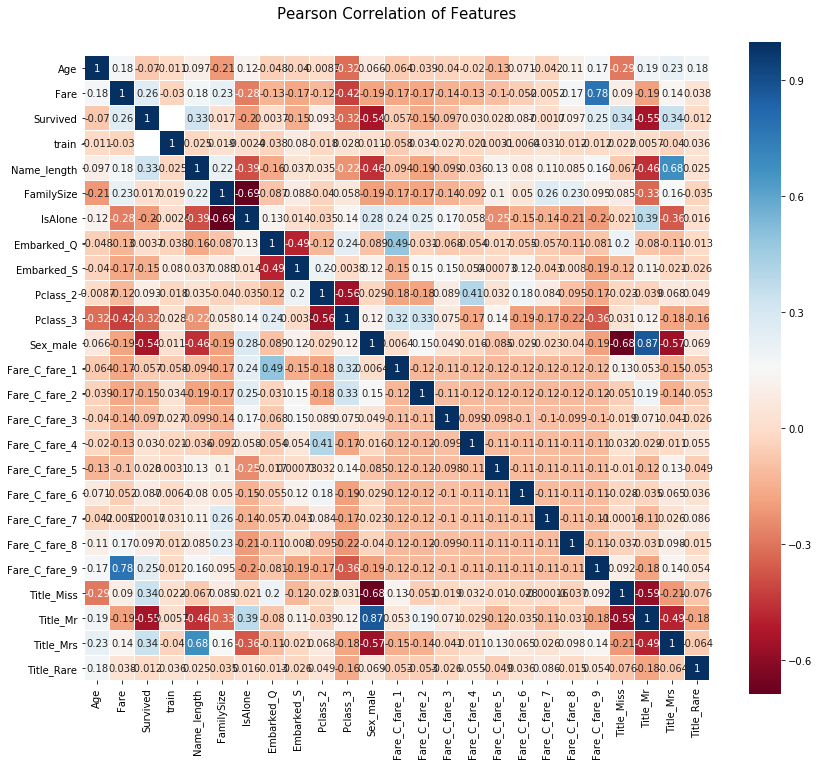

In [84]:
colormap = plt.cm.RdBu
plt.figure(figsize=(14,12))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(data.astype(float).corr(), linewidths=0.1, vmax=1.0,
           square=True, cmap = colormap, linecolor='white', annot=True)

In [85]:
data.dtypes

Age              float64
Fare             float64
Survived         float64
train              int64
Name_length        int64
FamilySize         int64
IsAlone            int32
Embarked_Q         uint8
Embarked_S         uint8
Pclass_2           uint8
Pclass_3           uint8
Sex_male           uint8
Fare_C_fare_1      uint8
Fare_C_fare_2      uint8
Fare_C_fare_3      uint8
Fare_C_fare_4      uint8
Fare_C_fare_5      uint8
Fare_C_fare_6      uint8
Fare_C_fare_7      uint8
Fare_C_fare_8      uint8
Fare_C_fare_9      uint8
Title_Miss         uint8
Title_Mr           uint8
Title_Mrs          uint8
Title_Rare         uint8
dtype: object

In [86]:
data['Age'] = data['Age'].astype(int)
data['Fare'] = data['Fare'].astype(int)

In [87]:
data.dtypes

Age                int32
Fare               int32
Survived         float64
train              int64
Name_length        int64
FamilySize         int64
IsAlone            int32
Embarked_Q         uint8
Embarked_S         uint8
Pclass_2           uint8
Pclass_3           uint8
Sex_male           uint8
Fare_C_fare_1      uint8
Fare_C_fare_2      uint8
Fare_C_fare_3      uint8
Fare_C_fare_4      uint8
Fare_C_fare_5      uint8
Fare_C_fare_6      uint8
Fare_C_fare_7      uint8
Fare_C_fare_8      uint8
Fare_C_fare_9      uint8
Title_Miss         uint8
Title_Mr           uint8
Title_Mrs          uint8
Title_Rare         uint8
dtype: object

# Ensembling

In [88]:
train = data[data['train']==1]
test = data[data['train']==0]

In [89]:
test.drop(['Survived'], axis = 1, inplace=True)

In [90]:
train.drop(['train'], axis=1, inplace = True)
test.drop(['train'], axis=1, inplace = True)

In [91]:
data.drop(['train'], axis=1, inplace = True)

In [92]:
ntrain = train.shape[0]
ntest = test.shape[0]
SEED = 0
NFOLDS = 5
kf = KFold(n_splits=NFOLDS, random_state=SEED)

In [93]:
class SklearnHelper(object):
    def __init__(self, clf, seed=0, params=None):
        params['random_state'] = seed
        self.clf = clf(**params)
    def train(self, x_train, y_train):
        self.clf.fit(x_train, y_train)
    def predict(self, x):
        return self.clf.predict(x)
    def fit(self,x,y):
        return self.clf.fit(x,y)
    def feature_importances(self,x,y):
        return(self.clf.fit(x,y).feature_importances_)

In [94]:
def get_oof(clf, x_train, y_train, x_test):
    oof_train = np.zeros((ntrain,))
    oof_test = np.zeros((ntest,))
    oof_test_skf = np.empty((NFOLDS, ntest))
    
    for i, (train_index, test_index) in enumerate(kf.split(x_train)):
        x_tr = x_train[train_index]
        y_tr = y_train[train_index]
        x_te = x_train[test_index]

        clf.train(x_tr, y_tr)

        oof_train[test_index] = clf.predict(x_te)
        oof_test_skf[i, :] = clf.predict(x_test)
            
    oof_test[:] = oof_test_skf.mean(axis=0)
    return oof_train.reshape(-1, 1), oof_test.reshape(-1, 1)

In [95]:
# Put in our parameters for said classifiers
# Random Forest parameters
rf_params = {
    'n_jobs': -1,
    'n_estimators': 500,
     'warm_start': True, 
     #'max_features': 0.2,
    'max_depth': 6,
    'min_samples_leaf': 2,
    'max_features' : 'sqrt',
    'verbose': 0
}

# Extra Trees Parameters
et_params = {
    'n_jobs': -1,
    'n_estimators':500,
    #'max_features': 0.5,
    'max_depth': 8,
    'min_samples_leaf': 2,
    'verbose': 0
}

# AdaBoost parameters
ada_params = {
    'n_estimators': 500,
    'learning_rate' : 0.75
}

# Gradient Boosting parameters
gb_params = {
    'n_estimators': 500,
     #'max_features': 0.2,
    'max_depth': 5,
    'min_samples_leaf': 2,
    'verbose': 0
}

# Support Vector Classifier parameters 
svc_params = {
    'kernel' : 'linear',
    'C' : 0.025
    }

In [96]:
rf = SklearnHelper(clf=RandomForestClassifier, seed=SEED, params=rf_params)
et = SklearnHelper(clf=ExtraTreesClassifier, seed=SEED, params=et_params)
ada = SklearnHelper(clf=AdaBoostClassifier, seed=SEED, params=ada_params)
gb = SklearnHelper(clf=GradientBoostingClassifier, seed=SEED, params=gb_params)
svc = SklearnHelper(clf=SVC, seed=SEED, params=svc_params)

In [97]:
y_train = train['Survived'].ravel()
train = train.drop(['Survived'], axis=1)
x_train = train.values
x_test = test.values

In [98]:
# Create our OOF train and test predictions. These base results will be used as new features
et_oof_train, et_oof_test = get_oof(et, x_train, y_train, x_test) # Extra Trees
rf_oof_train, rf_oof_test = get_oof(rf,x_train, y_train, x_test) # Random Forest
ada_oof_train, ada_oof_test = get_oof(ada, x_train, y_train, x_test) # AdaBoost 
gb_oof_train, gb_oof_test = get_oof(gb,x_train, y_train, x_test) # Gradient Boost
svc_oof_train, svc_oof_test = get_oof(svc,x_train, y_train, x_test) # Support Vector Classifier

print("Training is complete")

Training is complete


In [105]:
rf_features = rf.feature_importances(x_train, y_train).tolist()
et_features = et.feature_importances(x_train, y_train).tolist()
ada_features = ada.feature_importances(x_train, y_train).tolist()
gb_features = gb.feature_importances(x_train,y_train).tolist()

In [106]:
print(rf_features)
print(et_features)
print(ada_features)
print(gb_features)

[0.0684687742140881, 0.1134531081463478, 0.07945768965385827, 0.053343480596543785, 0.014613919966760614, 0.00424303067079961, 0.017963196419718108, 0.01730568328251911, 0.09311185657875751, 0.18233493056071481, 0.0034853375282613637, 0.004240145901380464, 0.0060720554311188635, 0.0034163669099413385, 0.005789584604244389, 0.006492925244188015, 0.008066065465164038, 0.009095322028769073, 0.019841293563048285, 0.04226012070824474, 0.2031899534508999, 0.0370974283608916, 0.006657730713740587]
[0.022083002306370364, 0.03132720981468644, 0.03255017299690896, 0.033737955182117065, 0.021231502028858533, 0.008713820071025963, 0.022460126649876833, 0.026225660320397956, 0.1078994612545792, 0.19717048543667484, 0.001732251894163337, 0.005382495572704616, 0.008289427524580777, 0.007748883976751958, 0.008409831168230141, 0.008034072464416434, 0.01520979565496527, 0.01410688275769548, 0.027713596471162394, 0.07097384641735903, 0.24337258099339704, 0.07371105582246157, 0.011915883220615823]
[0.278,

In [107]:
cols = train.columns.values
# Create a dataframe with features
feature_dataframe = pd.DataFrame( {'features': cols,
     'Random Forest feature importances': rf_features,
     'Extra Trees  feature importances': et_features,
      'AdaBoost feature importances': ada_features,
    'Gradient Boost feature importances': gb_features
    })

In [108]:
feature_dataframe

,features,Random Forest feature importances,Extra Trees feature importances,AdaBoost feature importances,Gradient Boost feature importances
0,Age,0.068469,0.022083,0.278,0.148012
1,Fare,0.113453,0.031327,0.342,0.127540
2,Name_length,0.079458,0.032550,0.204,0.115480
3,FamilySize,0.053343,0.033738,0.022,0.073853
4,IsAlone,0.014614,0.021232,0.010,0.002374
5,Embarked_Q,0.004243,0.008714,0.004,0.005438
6,Embarked_S,0.017963,0.022460,0.008,0.015404
7,Pclass_2,0.017306,0.026226,0.014,0.017757
8,Pclass_3,0.093112,0.107899,0.028,0.062222
9,Sex_male,0.182335,0.197170,0.002,0.006584


In [ ]:
np.zeros((ntrain)).shape

In [ ]:
np.empty((NFOLDS, ntest)).shape
